## Image classification with Convolutional Neural Networks

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd

In [4]:
## This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *


PATH = "data/plant-seed/"
sz=224
arch=resnext50
bs=64

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

In [7]:
os.listdir(PATH)

['submission_res.csv',
 'train',
 'sample',
 'remove_directory_retain_files.sh',
 '.kaggle-cli',
 'list_of_seeds',
 'train.zip',
 'tmp',
 'sample_submission.csv.zip',
 'test.zip',
 'list_of_seeds.dat',
 'submission.csv',
 'models',
 'labels.csv',
 'submission_res_2.csv',
 'create_label.py',
 'test']

In [9]:
#Read reads into df
labels_csv = f'{PATH}labels.csv'
import pandas as pd
labels_df = pd.read_csv(labels_csv)
labels_df.head()

,file,species
0,085df38fb.png,Common-Chickweed
1,a3e3b178c.png,Common-Chickweed
2,ef9e034f0.png,Common-Chickweed
3,037295da4.png,Common-Chickweed
4,b962fdcfc.png,Common-Chickweed


In [10]:

labels_df['species']=labels_df.species.str.replace(" ","-")
labels_df.species.value_counts()


Loose-Silky-bent             654
Common-Chickweed             611
Scentless-Mayweed            516
Small-flowered-Cranesbill    496
Fat-Hen                      475
Charlock                     390
Sugar-beet                   385
Cleavers                     287
Black-grass                  263
Shepherds-Purse              231
Maize                        221
Common-wheat                 221
Name: species, dtype: int64

In [11]:
n = len(labels_df)
val_idx = get_cv_idxs(n)
val_idx = val_idx[:2000]

In [12]:
#define architecture for first attempt
# sz=224 #image size
# arch=resnet34 #model
# bs=24 #batch size


#define architecture for second attempt
sz=224 #image size
arch=resnext50 #model
bs=64 #batch size

In [13]:
def get_augs():
    data = ImageClassifierData.from_csv(PATH, folder='train', csv_fname=f'{PATH}labels.csv',
                                        val_idxs=val_idx, bs=bs, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [14]:
ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)


NameError: name 'tfms' is not defined

In [ ]:
??tfms_from_model

In [15]:
#create data
#tfms=tfms_from_model(arch,sz,aug_tfms=transforms_side_on,max_zoom=1.1)
tfms=tfms_from_model(arch,sz,aug_tfms=transforms_top_down,max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH,"train",'data/plant-seed/labels.csv',val_idxs=val_idx,test_name='test',tfms=tfms,bs=bs,num_workers=4)

In [16]:
#compile learn model
#turn precompute to true to quickly train model
learn = ConvLearner.pretrained(arch,data,precompute=True,ps=0.5)

In [17]:
learn

Sequential(
  (0): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True)
  (1): Dropout(p=0.5)
  (2): Linear(in_features=4096, out_features=512, bias=True)
  (3): ReLU()
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=512, out_features=12, bias=True)
  (7): LogSoftmax()
)

In [18]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 72%|███████▏  | 43/60 [00:02<00:00, 20.19it/s, loss=11]  


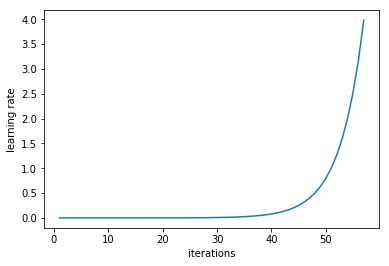

In [19]:
learn.sched.plot_lr()

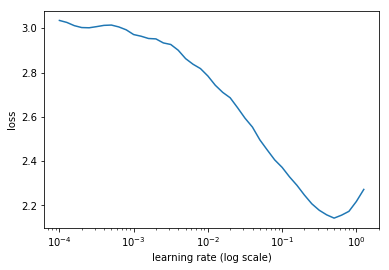

In [20]:
learn.sched.plot()

In [21]:
#fit model
learn.fit(1e-2, 5)
#turn precompute off to use data augmentations
learn.precompute=False

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.28761    0.657056   0.795216  
    1      0.853264   0.48671    0.836227                  
    2      0.66449    0.452186   0.853086                  
    3      0.585658   0.410355   0.870795                  
    4      0.508619   0.371516   0.875347                  



In [22]:
#learn with precompute false
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.627059   0.357944   0.889082  
    1      0.631679   0.366677   0.878279                  
    2      0.591721   0.340655   0.891821                  
    3      0.578047   0.344899   0.891358                  
    4      0.576206   0.341395   0.886998                  
    5      0.526122   0.326364   0.896181                  
    6      0.515445   0.32769    0.897222                  



[0.32768953, 0.8972222208976746]

In [ ]:
lrf=learn.lr_find()

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.sched.plot()

In [23]:
learn.unfreeze()

In [24]:
l1r=1e-2

In [25]:
lr=np.array([l1r/9,l1r/3,l1r])

In [26]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.461377   0.197982   0.934645  
    1      0.294292   0.140392   0.944406                  
    2      0.208268   0.126689   0.946682                  
    3      0.18513    0.123226   0.951698                  
    4      0.151039   0.10498    0.964198                  
    5      0.111069   0.083323   0.974614                  
    6      0.087498   0.080155   0.973765                   



[0.08015508, 0.9737654328346252]

In [ ]:
data.classes

In [27]:
learn.save('my_resnet50_plant_specie2s')
learn.load('my_resnet50_plant_specie2s')

In [28]:
#return test preds
test_preds,y = learn.TTA(is_test=True)

In [29]:
test_preds.shape

(5, 794, 12)

In [36]:
#get the mean value of the preds TTA does emsombling
preds_avg = np.mean(test_preds, axis=0)
preds_avg[:5]

array([[-20.39044,  -9.92041, -11.82491,  -9.87546, -18.82068, -15.3406 , -18.32604, -15.34556, -11.14186,
         -0.00035,  -9.90185, -17.4388 ],
       [-20.80228, -16.34082, -18.53052, -16.97485, -21.9897 , -20.94354, -16.8854 , -19.31449, -18.14067,
        -15.45263,   0.     , -25.13406],
       [-15.49767, -15.46663, -14.89355,  -9.87008, -18.43945, -17.34583, -12.90391, -14.46539, -14.25676,
        -11.99866,  -0.00014, -19.92937],
       [-11.37201, -11.56624,  -9.03126,  -7.89216,  -7.29354,  -8.12556, -11.60282,  -7.78781,  -7.66031,
         -9.66981, -13.79531,  -0.00294],
       [ -5.62215, -17.15509, -15.531  , -15.08007, -14.03905, -15.80853,  -0.00503, -17.83076, -10.24499,
        -15.81536, -14.43162, -18.30353]], dtype=float32)

In [37]:
#select column with highest pred
preds = np.argmax(preds_avg, axis=1)
#create array of probabilies, values are log of probabilities
probs = np.exp(preds_avg)

In [ ]:
preds[:5]

In [ ]:
probs[:5]

In [34]:
#data.test_ds.fnames
probs.shape
probs[:]
preds_avg[:]

array([ 9, 10, 10, 11,  6,  7,  0,  5, 10,  3,  9,  9,  6,  2,  1,  2,  3,  3,  7,  6,  2,  6,  2,  0,  8,
        5,  0, 11,  8, 10,  9, 11,  3,  8,  1,  9,  1,  2,  3, 11,  1,  1,  5,  9, 10,  6,  8,  6,  5,  9,
        9,  5,  3,  9,  4,  1,  4,  2,  8, 11,  3,  7,  8,  2,  9,  3,  8, 11,  2,  1,  9,  8,  3,  0, 10,
        3,  6,  3,  9, 10,  6,  1,  0,  6,  7,  6,  7,  9,  6,  4, 11,  5,  4,  5, 11,  2,  4,  0,  2,  8,
        5,  5,  8,  0,  5, 11, 10, 11, 11,  8,  1, 10,  1,  9,  2, 11, 10,  9,  3,  8,  2,  5, 11,  1,  2,
        4,  6, 10,  5, 10,  6,  5,  5,  5,  5,  6, 11,  6,  3, 11,  3,  6,  3, 11,  6,  7,  1,  3,  3,  5,
        0,  1,  6,  2,  7,  8,  3,  5,  8, 11,  6,  3,  1,  0,  3,  0,  3,  1,  3,  3, 10, 10,  4, 10,  1,
        3, 11, 11,  5,  8, 10,  6,  1,  6,  6,  0,  6,  3,  3,  1,  7,  8, 11,  3,  1,  5,  3,  6,  6,  0,
        7, 11,  8,  8,  9,  3,  8,  9,  5, 10,  7,  6,  0,  8,  8,  5,  6, 10, 10,  9,  7,  5,  2,  6,  8,
        1,  8,  5,  7, 11,  1,  3,  3

In [ ]:
log_preds_test = learn.predict(is_test=True)
log_preds_test[:]
log_preds_test.shape

In [ ]:
preds_avg.shape

In [38]:
preds_avg = np.argmax(preds_avg, axis=1)
preds_classes = [data.classes[i].replace("-", " ") for i in preds_avg]
# probs = np.exp(preds_avg)

In [39]:
submission = pd.DataFrame({'file': os.listdir(f'{PATH}test'), 'species': preds_classes})
submission.to_csv('data/plant-seed/submission_res.csv', index=False)

In [ ]:
log_preds_test = np.argmax(log_preds_test, axis=1)
preds_classes = [data.classes[i].replace("-", " ") for i in log_preds_test]
# probs = np.exp(preds_avg)

In [ ]:
submission = pd.DataFrame({'file': os.listdir(f'{PATH}test'), 'species': preds_classes})
submission.to_csv('data/plant-seed/submission_res_2.csv', index=False)

In [ ]:
preds = np.argmax(test_preds, axis=1)
probs = np.exp(test_preds[:,1])

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
def updating(df, dict):
    dfupdate = pd.DataFrame(df, copy=True)
    for key, value in dict.items():
        dfupdate.replace(key, value, inplace=True)
    return dfupdate

In [ ]:
top1probs = probs
dict_class = {idx: value for idx, value in enumerate(data.classes)}
top1probs_val = updating(top1probs,dict_class)
top1probs_val

In [ ]:
ds=pd.DataFrame(top5probs_val)

In [ ]:
ds.insert(0,'id',[out[5:] for out in data.test_ds.fnames])

In [ ]:

ds_submit=ds[['id',3]]
ds_submit.head()

In [ ]:
ds_submit.to_csv('plant_seed.csv',index=False)

In [ ]:
ds=pd.DataFrame(probs)
ds.columns = data.classes

In [ ]:
preds

In [ ]:
ds.insert(0,'id',[o[5:] for o in data.test_ds.fnames]) #file name contains 5 letters at start we don't want "/test" and also ".jpg" at end we don't want


In [ ]:
ds.head()